#Imports

In [12]:
import glob
import os
import math

from time import time

import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.imagenet_utils import preprocess_input

import keras.backend as K

from keras import Model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Input
from keras.models import load_model
from keras.optimizers import Adam
from skimage import color
from multiprocessing import Pool
from keras.layers import Conv2D, Dense, GlobalAveragePooling2D, LSTM, TimeDistributed, UpSampling2D
from keras.engine import Layer
from keras.utils import plot_model

from collections import namedtuple
from datetime import datetime
from os import listdir
from os.path import join, isfile

import re
import cv2
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


#Mount Drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Fusion Layer

In [0]:
class FusionLayer(Layer):
    def __init__(self, **kwargs):
        super(FusionLayer, self).__init__(**kwargs)

    def call(self, inputs, mask=None):
        enc_out, incep_out, rnn_out = inputs
        enc_out_shape = enc_out.shape.as_list()
        batch_size, time_steps, h, w, _ = map(lambda x: -1 if x is None else x, enc_out_shape)

        def _repeat(emb):
            # keep batch_size, time_steps axes unchanged
            # while replicating features h*w times
            emb_rep = K.tile(emb, [1, 1, h * w])
            return K.reshape(emb_rep, (batch_size, time_steps, h, w, emb.shape[2]))

        incep_rep = _repeat(incep_out)
        rnn_rep = _repeat(rnn_out)
        return K.concatenate([enc_out, incep_rep, rnn_rep], axis=4)

    def compute_output_shape(self, input_shapes):
        enc_out_shape, incep_out_shape, rnn_out_shape = input_shapes

        # Must have 3 tensors as input
        assert input_shapes and len(input_shapes) == 3

        # Batch size of the three tensors must match
        assert enc_out_shape[0] == incep_out_shape[0] == rnn_out_shape[0]

        # Number of time steps of the three tensors must match
        assert enc_out_shape[1] == incep_out_shape[1] == rnn_out_shape[1]

        # batch_size, time_steps, h, w, enc_out_depth = map(lambda x: -1 if x == None else x, enc_out_shape)
        batch_size, time_steps, h, w, enc_out_depth = enc_out_shape
        final_depth = enc_out_depth + incep_out_shape[2] + rnn_out_shape[2]
        return batch_size, time_steps, h, w, final_depth


# Functions

In [0]:
def post_process_predictions(original_l_layers, predicted_AB_layers):
    '''
    Combine original L layer and predicted AB Layers
    '''
    time_steps = frames_per_video
    total_frames = original_l_layers.shape[0]
    predicted_frames = []
    for i in range(total_frames):
        l_layer = original_l_layers[i]
        a_layer = np.multiply(predicted_AB_layers[i, time_steps - 1, :, :, 0],
                              128)  # select the first frame outof three predictions
        b_layer = np.multiply(predicted_AB_layers[i, time_steps - 1, :, :, 1], 128)
        frame = np.empty((240, 320, 3))
        frame[:, :, 0] = l_layer
        frame[:, :, 1] = a_layer
        frame[:, :, 2] = b_layer
        # frame = color.lab2rgb(frame)
        predicted_frames.append(frame)
    return np.asarray(predicted_frames)


def save_output_video(frames, output_file):
    '''
    Save the output video
    '''
    fps = 20
    size = (320, 240)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_file, fourcc, fps, size)
    for frame in frames:
        final_out = color.lab2rgb(frame)
        final_out_write_video = final_out * 255  # color.lab2rgb results values in [0,1]
        final_out_write_video = final_out_write_video.astype(np.uint8)
        out.write(final_out_write_video)
    out.release()
    
def getInputRange(frames_count, time_steps, current_frame):
    '''
    Deciding the moving window
    '''
    # this function should change according to our selection of
    frame_selection = []
    last_selection = current_frame
    for i in range(current_frame, current_frame - time_steps, -1):
        if (i < 0):
            frame_selection.append(last_selection)
        else:
            frame_selection.append(i)
            last_selection = i
    frame_selection = frame_selection[::-1]
    return frame_selection

def get_nn_input(l_layer, resnet_out):
    '''
    Define the flowchroma input
    '''
    frames_count = l_layer.shape[0]
    time_steps = frames_per_video
    X = []
    Y = []

    for i in range(frames_count):
        frame_index_selection = getInputRange(frames_count, time_steps, i)
        frame_selection = []
        resnet_selection = []
        for j in frame_index_selection:
            frame_selection.append(l_layer[j])
            resnet_selection.append(resnet_out[j])
        X.append(frame_selection)
        Y.append(resnet_selection)

    X = np.asarray(X)
    Y = np.asarray(Y)
    return [X, Y]

def get_resnet_records(frames):
    '''
    Parameters
    ----------
    frames - original frames without color conversion or resizing

    Details
    -------
    Implementation adopted from Deep Kolorization implementation

    Returns
    -------
    predictions - restnet predictions
    '''
    resnet_input = []
    for frame in frames:
        resized_frame = resize_pad_frame(frame, (resnet_input_height, resnet_input_width))
        gray_scale_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2GRAY)
        gray_scale_frame_colored = cv2.cvtColor(gray_scale_frame, cv2.COLOR_GRAY2RGB)
        resnet_input.append(gray_scale_frame_colored)
    resnet_input = np.asarray(resnet_input)

    predictions = inception_resnet_v2_predict(resnet_input)
    return predictions

def preprocess_frames(gray2lab_frames):
    '''
    Parameters
    ---------
    gray2lab_frames - LAB frames of Grayscale video

    Returns
    -------
    processed_l_layer - L Layer processed (L/50 - 1)
    '''
    processed = np.empty(gray2lab_frames.shape)

    processed[:, :, :, 0] = np.divide(gray2lab_frames[:, :, :, 0], 50) - 1  # data loss
    processed[:, :, :, 1] = np.divide(gray2lab_frames[:, :, :, 1], 128)
    processed[:, :, :, 2] = np.divide(gray2lab_frames[:, :, :, 2], 128)

    processed_l_layer = processed[:, :, :, np.newaxis, 0]

    return processed_l_layer

def get_lab_layer(frames):
    '''
        Parameters
        -----------
        frames - color/gray video frames with 3 chanels

        Returns
        -------
        (rgb2lab, gray2lab) - RGB frames converted to LAB, GRAY frames converted to LAB
    '''
    rgb2lab_frames = []
    gray2lab_frames = []

    for frame in frames:
        resized_frame = resize_pad_frame(frame, (default_nn_input_height, default_nn_input_width), equal_padding=True)

        rgb2lab_frame = color.rgb2lab(resized_frame)
        rgb2lab_frames.append(rgb2lab_frame)

        rgb2gray_frame = color.rgb2gray(resized_frame)

        #         Display Grayscale frame
        #         cv2.imshow('grey', rgb2gray_frame)
        #         cv2.waitKey(0)
        #         cv2.destroyAllWindows()

        gray2rgb_frame = color.gray2rgb(rgb2gray_frame)
        lab_frame = color.rgb2lab(gray2rgb_frame)
        gray2lab_frames.append(lab_frame)

    return np.asarray(rgb2lab_frames), np.asarray(gray2lab_frames)


def get_video(file):
    '''
    Parameters
    ----------
    file - path to video file

    Returns
    -------
    frames - frames array of the video
    '''

    video = cv2.VideoCapture(file)
    frames = []
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        frames.append(frame)
    frames = np.asarray(frames)
    return frames

def process_test_file(file):
    # Pre-processing
    frames = get_video(dir_test+'/'+file)
    (rgb2lab_frames, gray2lab_frames) = get_lab_layer(frames)
    processed_l_layer = preprocess_frames(gray2lab_frames)
    print('running resnet model')
    predictions = get_resnet_records(frames)
    print('Combining L layer and resnet out')
    X = get_nn_input(processed_l_layer, predictions)

    # Predicting
    ckpts = glob.glob("/content/drive/My Drive/checkpoints_new/*.hdf5")
    latest_ckpt = max(ckpts, key=os.path.getctime)
    print("loading from checkpoint:", latest_ckpt)
    model = load_model(latest_ckpt, custom_objects={'FusionLayer': FusionLayer})
    predictions = []
    for i in range(X[0].shape[0]):
        predictions.append(model.predict([X[0][i:i + 1], X[1][i:i + 1]])[0])  # shape is (1, 3, 240, 320, 2)
    predictions = np.asarray(predictions)
    print("Flowchroma model predictions calculated")

    # Post processing
    frame_predictions = post_process_predictions(gray2lab_frames[:, :, :, 0], predictions)

    save_output_video(frame_predictions, dir_test_results+ '/' + file.split('.')[0] + '.avi')


### Resize Pad Frame

In [0]:
def resize_pad_frame(img, size, pad_color=255, equal_padding=True):
    """
    Resize the frame,
    If image is a horizontal one first match the horizontal axis then resize vertical axis and fill the remaining
    with padding color, similar process for vertical images
    :param equal_padding:
    :param img: frame to be resized
    :param size: final frame size
    :param pad_color: color of tha padding
    :return: re-sized frame
    """
    h, w = float(img.shape[0]), float(img.shape[1])
    expected_height, expected_width = size

    # interpolation method
    if h > expected_height or w > expected_width:  # shrinking image
        interp = cv2.INTER_AREA
    else:  # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w / h

    # compute scaling and pad sizing
    if aspect >= 1:  # horizontal image
        new_w = expected_width
        new_h = np.round(new_w / aspect).astype(int)
        if expected_height >= new_h:
            if equal_padding:
                pad_vert = (expected_height - new_h) / 2.0
                pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
                pad_left, pad_right = 0, 0
            else:
                pad_vert = (expected_height - new_h)
                pad_top, pad_bot = 0, pad_vert
                pad_left, pad_right = 0, 0
        else:
            new_h = expected_height
            new_w = np.round(new_h * aspect).astype(int)
            if equal_padding:
                pad_horz = (expected_width - new_w) / 2
                pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
                pad_top, pad_bot = 0, 0
            else:
                pad_horz = (expected_width - new_w)
                pad_left, pad_right = 0, pad_horz
                pad_top, pad_bot = 0, 0

    elif aspect < 1:  # vertical image
        new_h = expected_height
        new_w = np.round(new_h * aspect).astype(int)
        if expected_width >= new_w:
            if equal_padding:
                pad_horz = (expected_width - new_w) / 2
                pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
                pad_top, pad_bot = 0, 0
            else:
                pad_horz = (expected_width - new_w)
                pad_left, pad_right = 0, pad_horz
                pad_top, pad_bot = 0, 0
        else:
            new_w = expected_width
            new_h = np.round(new_w / aspect).astype(int)
            if equal_padding:
                pad_vert = (expected_height - new_h) / 2.0
                pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
                pad_left, pad_right = 0, 0
            else:
                pad_vert = (expected_height - new_h)
                pad_top, pad_bot = 0, pad_vert
                pad_left, pad_right = 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(pad_color,
                                              (list, tuple, np.ndarray)):  # color image but only one color provided
        pad_color = [pad_color] * 3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right,
                                    borderType=cv2.BORDER_CONSTANT, value=pad_color)

    return scaled_img


#Calling Functions

In [0]:
def inference():
  files = listdir(dir_test)
  for file in files:
      process_test_file(file)

# Old Configurations

In [0]:
dir_root = '/content/drive/My Drive'
dir_originals = join(dir_root, 'original')
dir_sampled = join(dir_root, 'sampled')
dir_resnet_images = join(dir_root, 'resized_resnet_images')
dir_resnet_csv = join(dir_root, 'resnet_csv_records')
dir_lab_records = join(dir_root, 'lab_records')
dir_tfrecord = join(dir_root, 'tfrecords')
dir_test = join(dir_root, 'test')
dir_test_results = join(dir_root, 'test_results')
dir_frame_lab_records = join(dir_root, 'frame_lab_records')
dir_frame_resnet_records = join(dir_root, 'frame_resnet_records')
checkpoint_url = join(dir_root,"updated_resnet_v2.h5")

frames_per_video = 3
default_nn_input_height = 240
default_nn_input_width = 320
resnet_input_height = 299
resnet_input_width = 299
resnet_video_chunk_size = 100
resnet_batch_size = 100

training_set_size = 2000
test_set_size = 239
validation_set_size = 200

resnet_output = 1000


def progressive_filename_generator(pattern='file_{}.ext'):
    for i in itertools.count():
        yield pattern.format(i)

# New Configurations

In [0]:
dir_root = '/content/drive/My Drive'
dir_originals = join(dir_root, 'original')
dir_sampled = join(dir_root, 'sampled_new')
dir_resnet_images = join(dir_root, 'resized_resnet_images_new')
dir_resnet_csv = join(dir_root, 'resnet_csv_records_new')
dir_lab_records = join(dir_root, 'lab_records_new')
dir_tfrecord = join(dir_root, 'tfrecords_new')
dir_test = join(dir_root, 'test')
dir_test_results = join(dir_root, 'test_results_new')
dir_frame_lab_records = join(dir_root, 'frame_lab_records_new')
dir_frame_resnet_records = join(dir_root, 'frame_resnet_records_new')
checkpoint_url = join(dir_root,"updated_resnet_v2.h5")

frames_per_video = 3
default_nn_input_height = 240
default_nn_input_width = 320
resnet_input_height = 299
resnet_input_width = 299
resnet_video_chunk_size = 100
resnet_batch_size = 100

training_set_size = 2000
test_set_size = 239
validation_set_size = 200

resnet_output = 1000


def progressive_filename_generator(pattern='file_{}.ext'):
    for i in itertools.count():
        yield pattern.format(i)

# Inception Model

In [20]:
K.clear_session()

x = InceptionResNetV2(include_top=True, weights='imagenet')
# load_model(checkpoint_url)
y = x.output
model = Model(inputs=x.input, outputs=y)


def inception_resnet_v2_predict(images):
    images = images.astype(np.float32)
    predictions = model.predict(preprocess_input(images))
    return predictions

#INference Init

In [28]:
!ls /content/drive/My\ Drive/test_results_new

amazaon-Scene-006_bl.avi  cheetah_black.avi


In [10]:
inference()

running resnet model
Combining L layer and resnet out
loading from checkpoint: /content/drive/My Drive/checkpoints_new/flowchroma-epoch-00261-lr-0.0001-train_loss-0.0003.hdf5


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Flowchroma model predictions calculated


# Inference Visualization

In [0]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

sns.set(rc={'figure.figsize':(20,8)})

In [0]:
frames = get_video('/content/drive/My Drive/test_bank/squirrel.mp4')

In [31]:
# get L layer
(rgb2lab_frames, gray2lab_frames) = get_lab_layer(frames)
processed_l_layer = preprocess_frames(gray2lab_frames)
print(processed_l_layer.shape)
print("Completed calculating L layer")

(49, 240, 320, 1)
Completed calculating L layer


In [0]:
# print(rgb2lab_frames.shape)
# print(np.amax(rgb2lab_frames[0,:,:,0]))
# sns.heatmap(rgb2lab_frames[0,80:90,80:90,0],annot=True )

In [0]:
# print(gray2lab_frames.shape)
# print(np.amax(gray2lab_frames[0,:,:,0]))
# sns.heatmap(gray2lab_frames[0,80:90,80:90,0],annot=True )

In [0]:
# print(processed_l_layer.shape)
# print(np.amax(processed_l_layer[0,:,:,0]))
# sns.heatmap(processed_l_layer[0,80:90,80:90,0],annot=True )

In [35]:
# get resnet embeddings
predictions = get_resnet_records(frames)
print("Completed calculating resnet records ")

Completed calculating resnet records 


#Comparison (Old Vs New)

## Result after epoch 261 [Old Model]

In [22]:
# run flowchroma model
latest_ckpt = "/content/drive/My Drive/checkpoints/flowchroma-epoch-00261-lr-0.0001-train_loss-0.0003.hdf5"
print("loading from checkpoint:", latest_ckpt)
model = load_model(latest_ckpt, custom_objects={'FusionLayer': FusionLayer})
X = get_nn_input(processed_l_layer, predictions)
predictions = model.predict(X)

print("Flowchroma model predictions calculated")

loading from checkpoint: /content/drive/My Drive/checkpoints/flowchroma-epoch-00261-lr-0.0001-train_loss-0.0003.hdf5
Flowchroma model predictions calculated


In [23]:
frame_predictions = post_process_predictions(gray2lab_frames[:,:,:,0], predictions)
print(frame_predictions.shape)
print(rgb2lab_frames.shape)

(44, 240, 320, 3)
(44, 240, 320, 3)


####L Layer

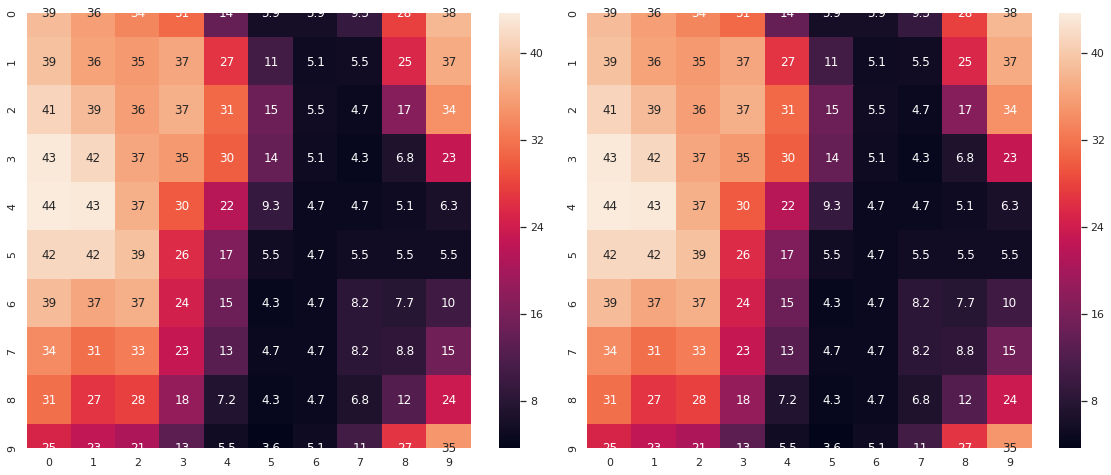

In [24]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)

sns.heatmap(frame_predictions[0,80:90,80:90,0],annot=True, ax=ax )
sns.heatmap(rgb2lab_frames[0,80:90,80:90,0],annot=True, ax=ax2 )

#### A Layer

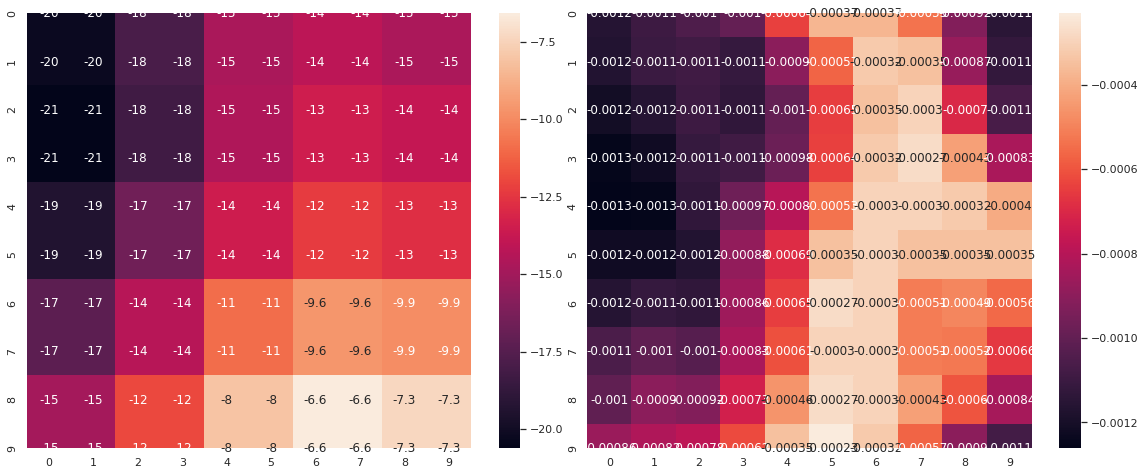

In [25]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(frame_predictions[0,80:90,80:90,1],annot=True, ax=ax )
sns.heatmap(rgb2lab_frames[0,80:90,80:90,1],annot=True, ax=ax2 )

####B Layer

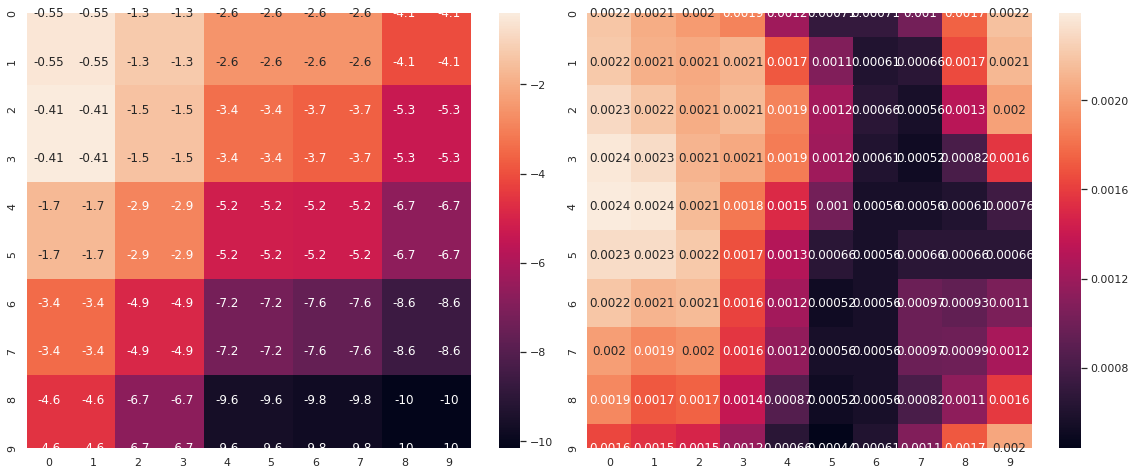

In [26]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(frame_predictions[0,80:90,80:90,2],annot=True, ax=ax )
sns.heatmap(rgb2lab_frames[0,80:90,80:90,2],annot=True, ax=ax2 )

## Result after epoch 261 [New Model]

In [36]:
# run flowchroma model
latest_ckpt = "/content/drive/My Drive/checkpoints_new/flowchroma-epoch-00261-lr-0.0001-train_loss-0.0003.hdf5"
print("loading from checkpoint:", latest_ckpt)
model = load_model(latest_ckpt, custom_objects={'FusionLayer': FusionLayer})
X = get_nn_input(processed_l_layer, predictions)
predictions = model.predict(X)

print("Flowchroma model predictions calculated")

loading from checkpoint: /content/drive/My Drive/checkpoints_new/flowchroma-epoch-00261-lr-0.0001-train_loss-0.0003.hdf5


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Flowchroma model predictions calculated


In [37]:
frame_predictions = post_process_predictions(gray2lab_frames[:,:,:,0], predictions)
print(frame_predictions.shape)
print(rgb2lab_frames.shape)

(49, 240, 320, 3)
(49, 240, 320, 3)


####L Layer

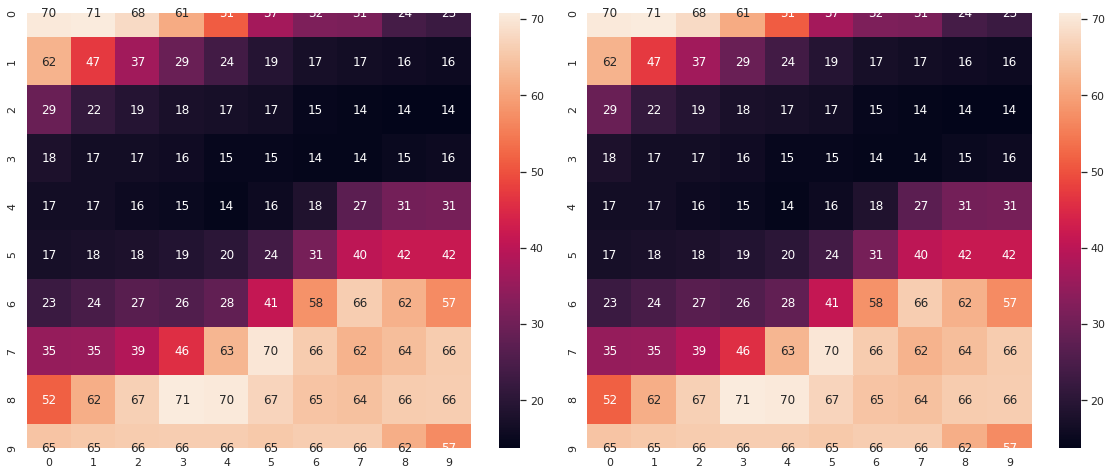

In [38]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)

sns.heatmap(frame_predictions[0,80:90,80:90,0],annot=True, ax=ax )
sns.heatmap(rgb2lab_frames[0,80:90,80:90,0],annot=True, ax=ax2 )

####A Layer

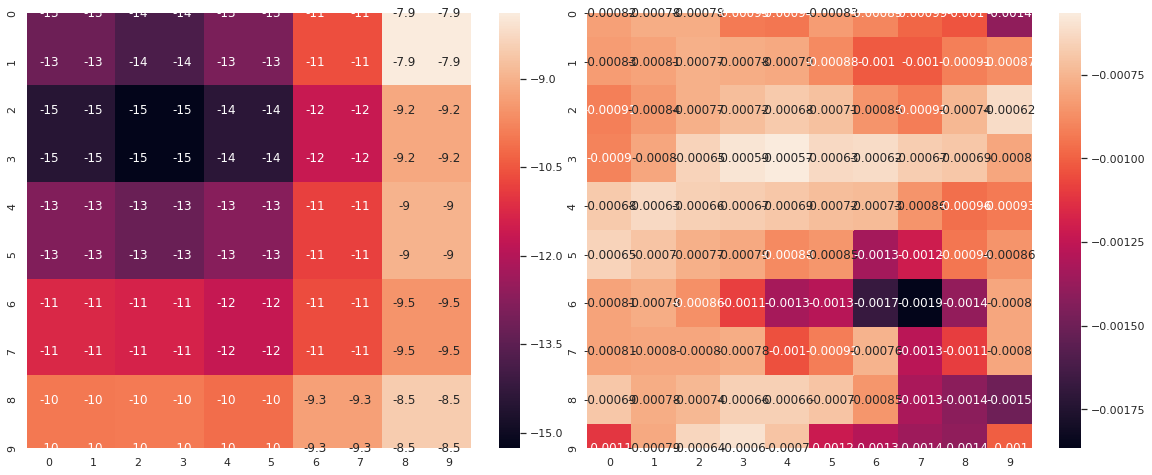

In [40]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(frame_predictions[0,40:50,40:50,1],annot=True, ax=ax )
sns.heatmap(rgb2lab_frames[0,40:50,40:50,1],annot=True, ax=ax2 )

#### BLayer

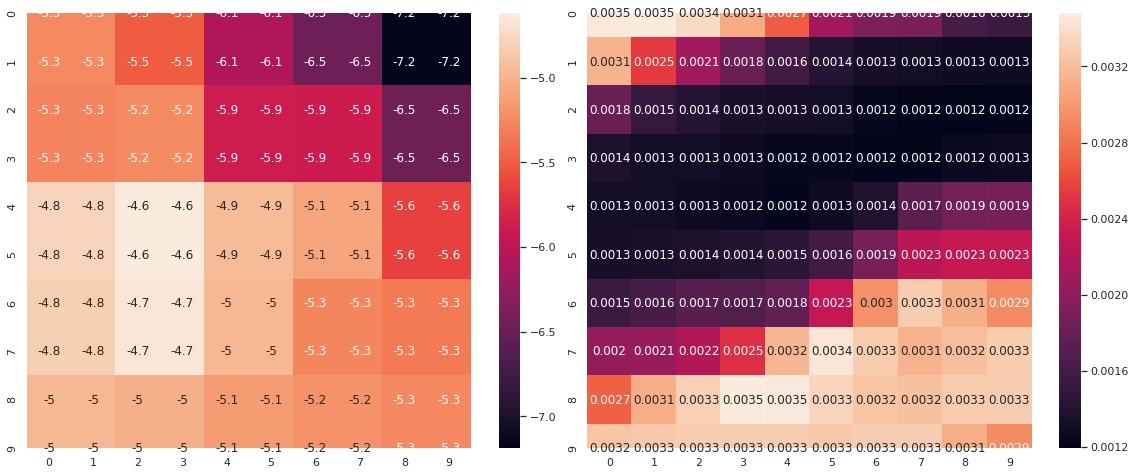

In [28]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(frame_predictions[0,80:90,80:90,2],annot=True, ax=ax )
sns.heatmap(rgb2lab_frames[0,80:90,80:90,2],annot=True, ax=ax2 )